<a href="https://colab.research.google.com/github/gianluigilopardo/text_mining/blob/master/tesina_bi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisi di un dataset di articoli finanziari
## Indice
1. Import
2. Estrazione degli articoli in lingua inglese
3. Visualizzazione dati
4. Preprocessing
  * 4.1 Pulitura testo
  * 4.2 Generazione delle matrici term-document
5. Clustering
  * 5.1 Determinazione del numero di cluster
  * 5.2 Generazione dei cluster 
6. Classificazione
  * 6.1 Sui cluster
  * 6.2 Sulle categorie

# Import

In [1]:
from google.colab import files

import io
import pandas as pd
import re
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
# models 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
#!pip install apyori
#from apyori import apriori

from collections import Counter, defaultdict

from numpy import random
SEED = 42 # 20
random.seed(SEED)

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

!pip install langdetect
from langdetect import detect 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 983kB 2.8MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=414e8f3edf0ba0c176906304c88e7dc30586e9a89cd86ccb165751acde49a173
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [2]:
# Upload original dataset: d-27.csv
uploaded = files.upload()

Saving d-27.csv to d-27.csv


In [3]:
df = pd.read_csv(io.BytesIO(uploaded['d-27.csv']))
df

,ts,body,stock,positive,negative
0,2011-01-14,* Sees adj. oper profit 140 mln stg vs 79.2...,DAL,2.0,1.0
1,2011-03-30,March 30 (Reuters) - Analog Devices Inc ADI....,BAC,0.0,0.0
2,2013-07-18,July 18 (Reuters) - The following are lists of...,GS,0.0,1.0
3,2013-02-27,WASHINGTON (Reuters) - U.S. regulators want st...,VZ,4.0,5.0
4,2011-04-19,SAN FRANCISCO (Reuters) - Intel Corp forecast ...,AAPL,9.0,21.0
...,...,...,...,...,...
1995,2011-12-28,"* Baidu, Autodesk among top holdings * Likes C...",TWTR,10.0,2.0
1996,2011-09-16,* Feingold’s assets under management rise 10-...,AAPL,4.0,11.0
1997,2015-01-15,"* Z1 model priced at $92, targets 1st-time sma...",AMZN,4.0,7.0
1998,2011-05-26,"* Q4 net profit 922 mln rupees, vs 2.27 bln r...",T,5.0,12.0


In [4]:
len(df)

2000

# Estrazione articoli in lingua inglese

In [5]:
# rimozione articoli in lingua diversa da inglese
df_eng = df.copy()
df_not_eng = df.copy()

for i_row in range(0,len(df)-1):
  if (detect(df.iloc[i_row]['body']) != 'en'):
    df_eng = df_eng.drop(i_row)
  else: df_not_eng = df_not_eng.drop(i_row)
df_eng

,ts,body,stock,positive,negative
0,2011-01-14,* Sees adj. oper profit 140 mln stg vs 79.2...,DAL,2.0,1.0
1,2011-03-30,March 30 (Reuters) - Analog Devices Inc ADI....,BAC,0.0,0.0
2,2013-07-18,July 18 (Reuters) - The following are lists of...,GS,0.0,1.0
3,2013-02-27,WASHINGTON (Reuters) - U.S. regulators want st...,VZ,4.0,5.0
4,2011-04-19,SAN FRANCISCO (Reuters) - Intel Corp forecast ...,AAPL,9.0,21.0
...,...,...,...,...,...
1995,2011-12-28,"* Baidu, Autodesk among top holdings * Likes C...",TWTR,10.0,2.0
1996,2011-09-16,* Feingold’s assets under management rise 10-...,AAPL,4.0,11.0
1997,2015-01-15,"* Z1 model priced at $92, targets 1st-time sma...",AMZN,4.0,7.0
1998,2011-05-26,"* Q4 net profit 922 mln rupees, vs 2.27 bln r...",T,5.0,12.0


In [6]:
df_not_eng

,ts,body,stock,positive,negative
8,2011-06-23,indiePub lança o Kona’s Crate para Android e ...,AMZN,0.0,0.0
181,2011-11-22,Digital River unterstützt globale Lancierung ...,TWTR,0.0,0.0
229,2011-02-24,MWV Healthcare arricchisce la sua linea di po...,DAL,1.0,0.0
475,2011-12-06,Merck implante un nouveau siège social en Asi...,TWTR,3.0,3.0
698,2011-11-15,"ROMA, 15 novembre (Reuters) - L’Ad di Finmecca...",TWTR,0.0,0.0
751,2011-10-06,"6 ottobre (Reuters) - Steve Jobs, co-fondator...",AAPL,2.0,0.0
839,2011-11-09,Pall Corp. presenta nuove tecnologie di produ...,DAL,0.0,0.0
910,2011-11-14,"VARSAVIA, 14 novembre (Reuters) - Bank Pekao ,...",TWTR,0.0,0.0
920,2011-12-20,"MADRID/MOSCA, 20 dicembre (Reuters) - La compa...",TWTR,0.0,0.0
935,2011-08-12,"STOCKHOLM, Aug 12 (Reuters) - STOCKHOLM, ...",T,0.0,0.0


In [0]:
# Download dataset con articoli in inglese
#df_eng.to_csv('d-27_eng.csv')#, encoding='utf-8')
#files.download('d-27_eng.csv')

# Visualizzazione dati

In [0]:
TECH = ['TECH','AAPL', 'GOOGL', 'AMZN', 'TWTR']
TLC = ['TLC','T', 'VZ']
BANK = ['BANK','GS', 'BAC']
AIR = ['AIR','DAL', 'LUV']

labels = [TLC,TECH,BANK,AIR]

y = []
for i_row in range(0, len(df_eng)):
  x = df_eng.iloc[i_row]['stock']
  for lab in labels:
    if(x in lab):
      y_lab = lab[0]
      y.append(y_lab)

label_categoria = y
df_eng['categoria'] = label_categoria

In [9]:
df_eng['categoria'].value_counts()

TECH    791
BANK    399
TLC     397
AIR     392
Name: categoria, dtype: int64

In [10]:
df_eng.describe()

,positive,negative
count,1979.000000,1979.000000
mean,3.990399,9.721071
std,4.980793,10.511923
min,0.000000,0.000000
25%,1.000000,2.000000
50%,3.000000,7.000000
75%,6.000000,14.000000
max,75.000000,152.000000


In [11]:
df_eng['stock'].value_counts()

GS       200
LUV      200
AMZN     199
GOOGL    199
BAC      199
VZ       199
AAPL     199
T        198
TWTR     194
DAL      192
Name: stock, dtype: int64

In [12]:
df_eng['ts'] = pd.to_datetime(df_eng['ts']) 
df_eng['year'] = df_eng['ts'].apply(lambda x: x.year)

df_eng = df_eng.sort_values(by = 'ts')
df_eng['ts'].apply(lambda x: x.year).unique()

array([2011, 2013, 2015])

In [0]:
index = []
for i_row in range(0, len(df_eng)):
  pos = df_eng.iloc[i_row]['positive']
  neg = df_eng.iloc[i_row]['negative']
  if(pos == 0):
    index.append(0)
  else: index.append((pos)/(pos+neg)*100)

df_eng['index'] = index

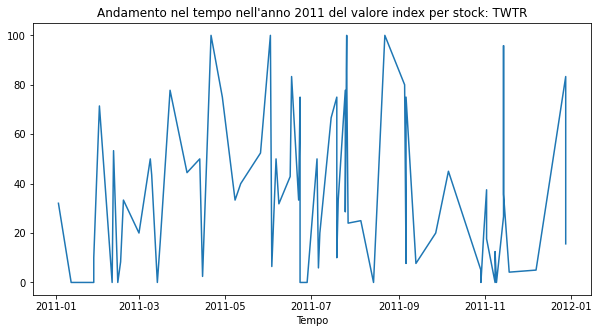

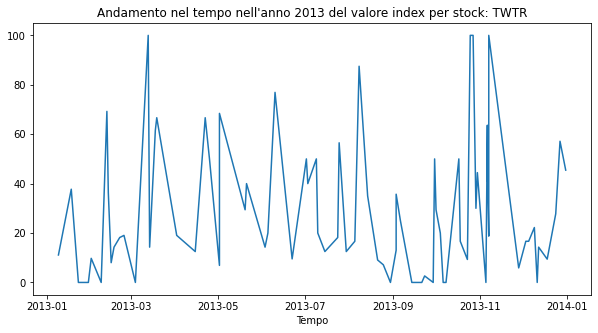

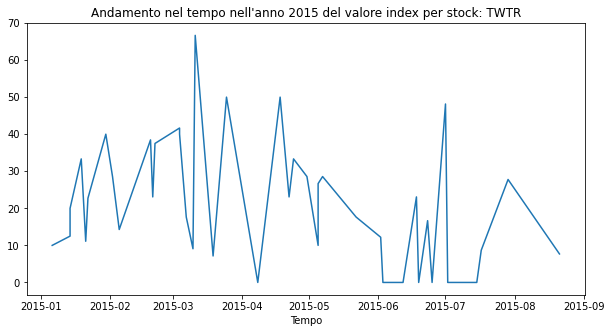

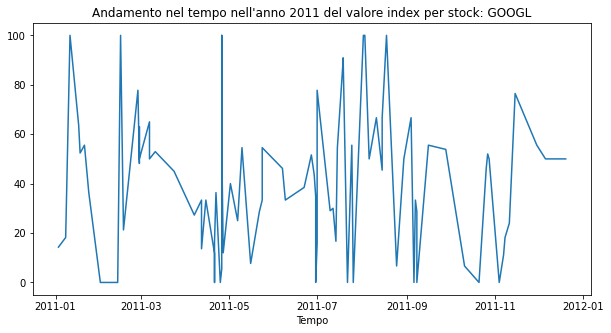

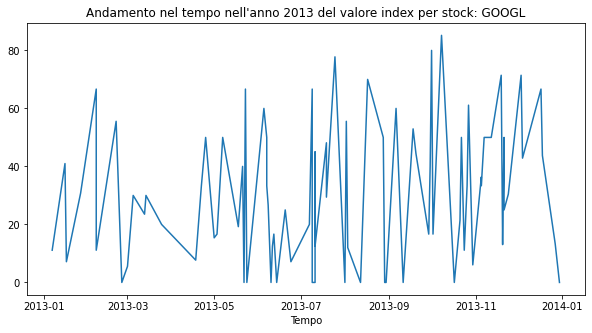

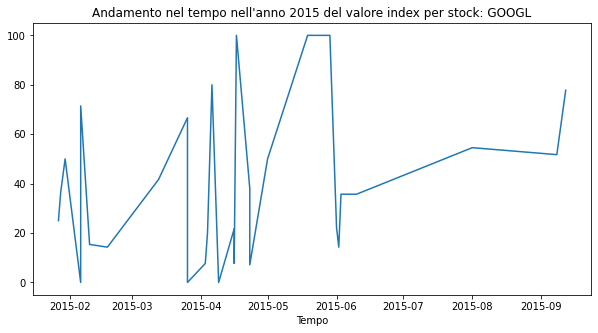

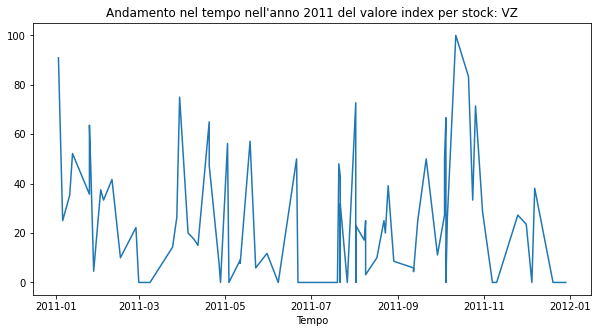

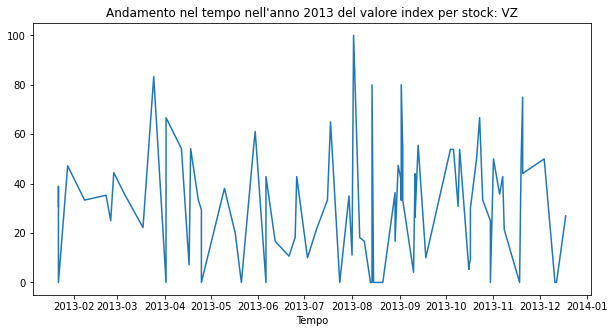

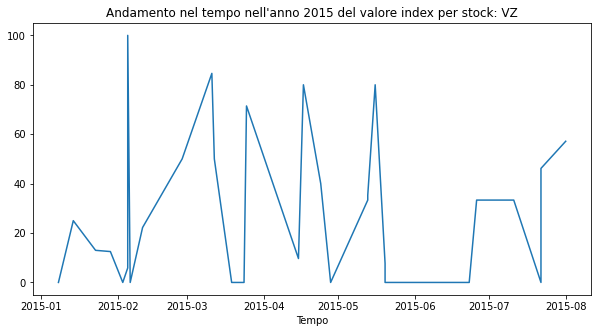

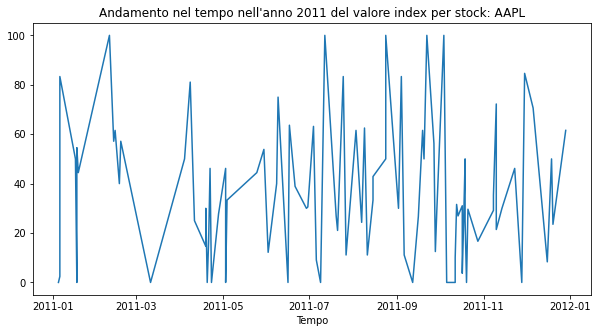

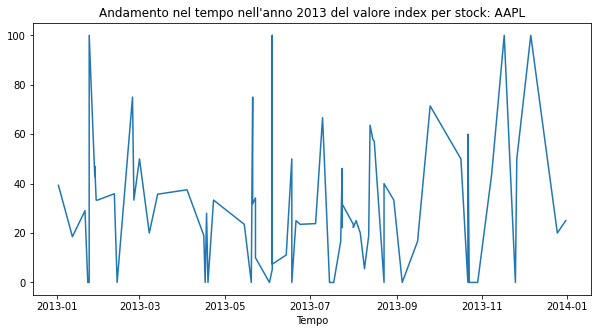

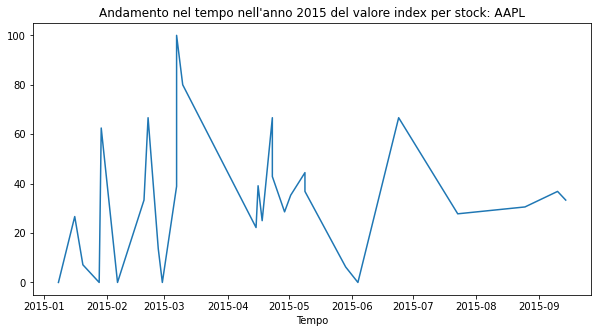

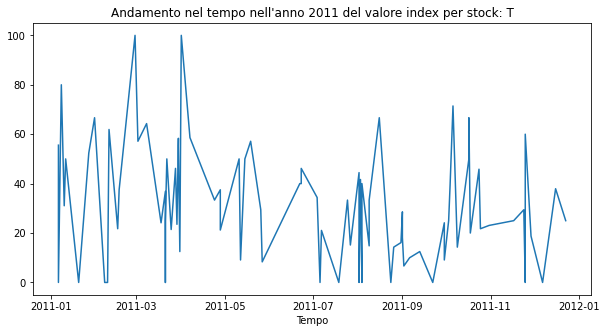

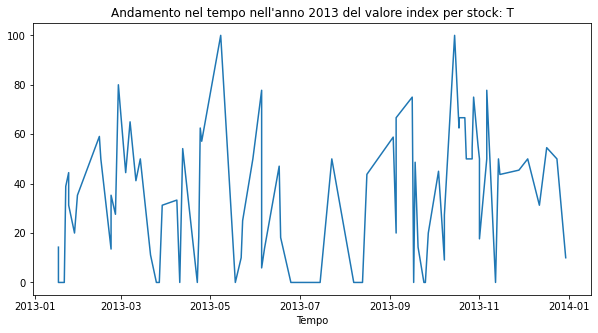

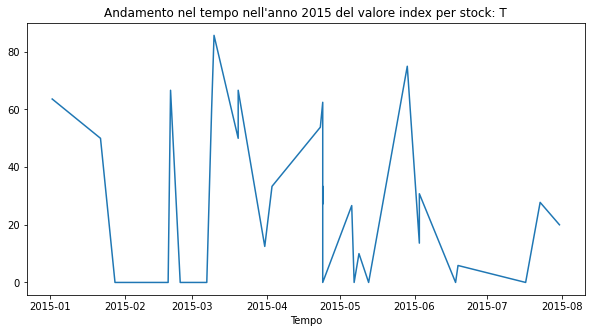

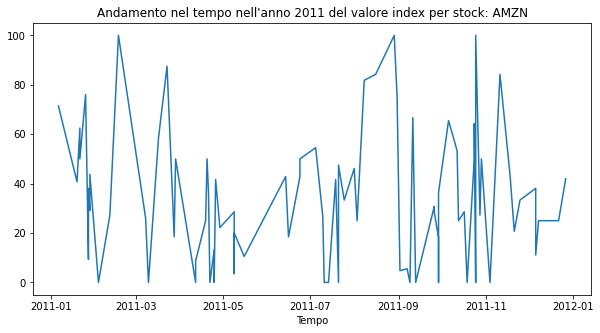

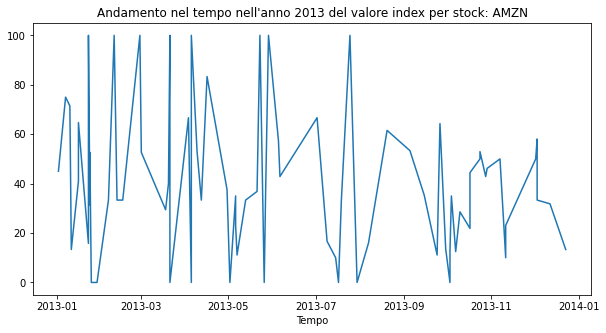

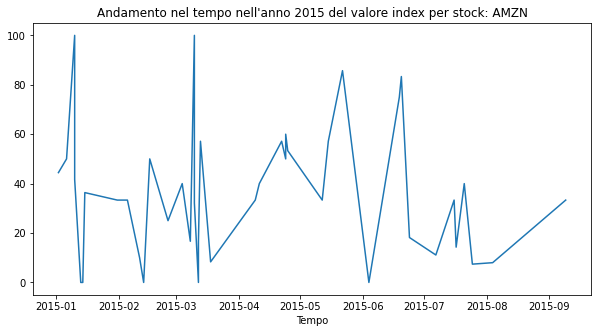

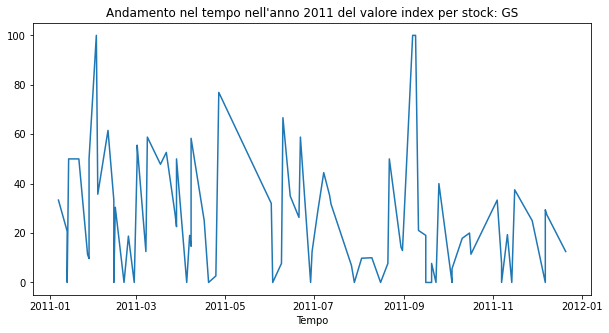

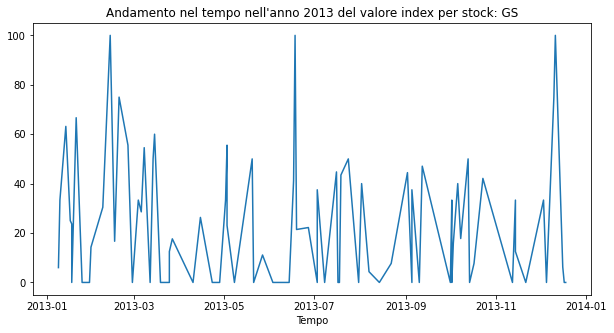

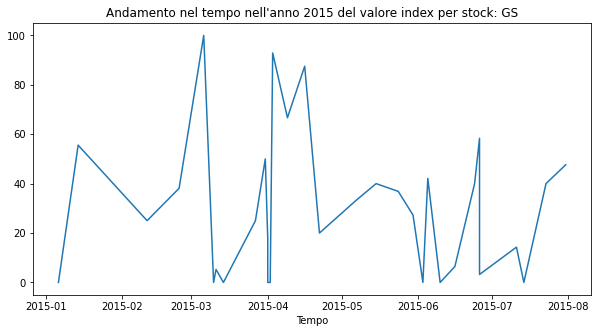

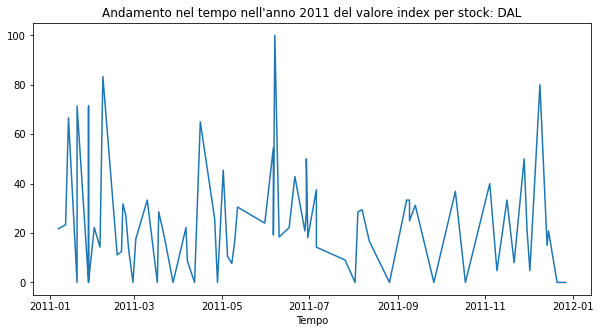

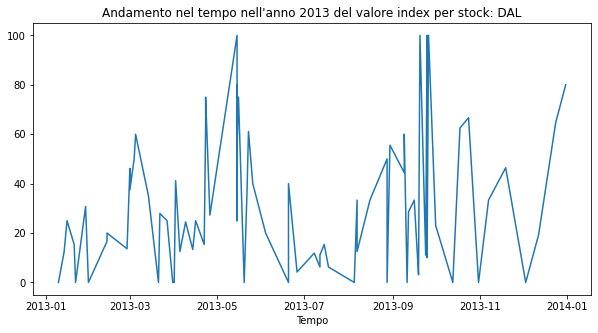

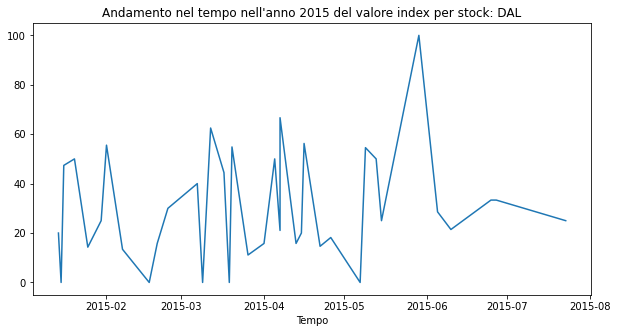

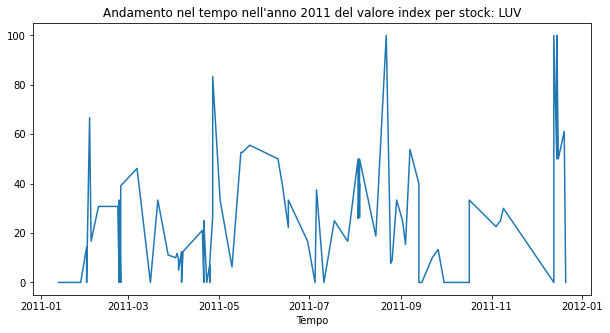

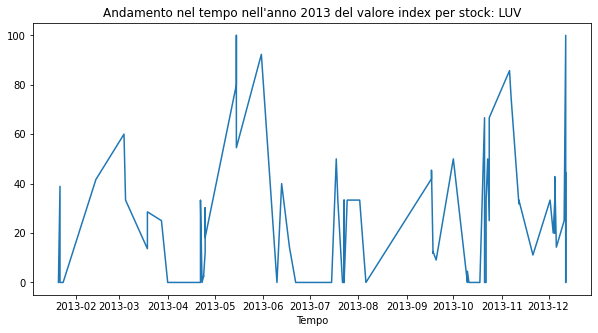

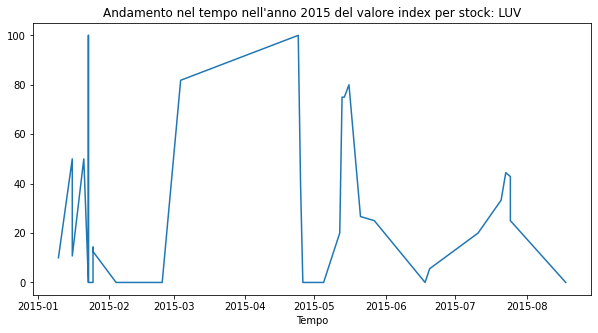

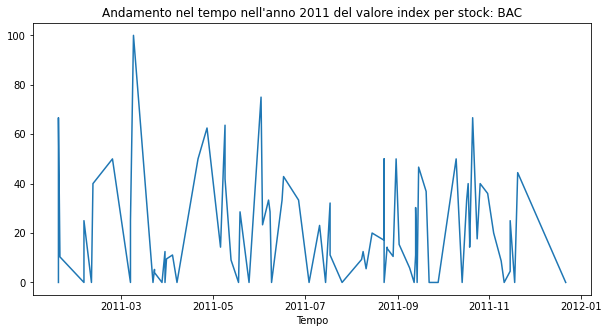

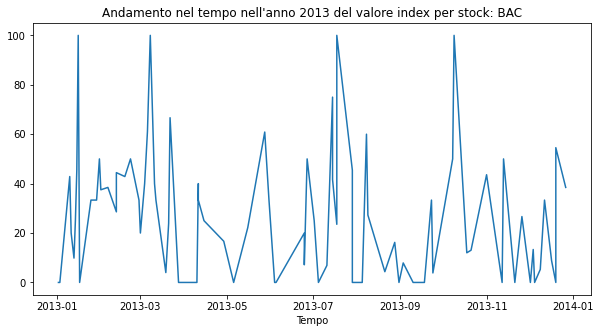

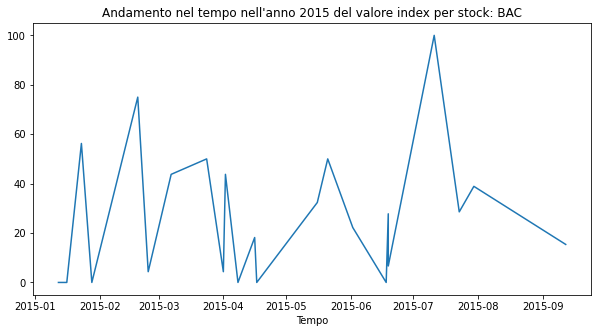

In [14]:
# Andamento nel tempo del valore index per ogni stock, per ogni anno
for act in df_eng['stock'].unique():
  for year in [2011,2013,2015]:
    df_year = df_eng[df_eng['ts'].apply(lambda x: x.year) == year]
    plt.figure(figsize = (10,5))
    plt.plot(df_year[df_year['stock'] == act]['ts'], df_year[df_year['stock'] == act]['index'])
    plt.title('Andamento nel tempo nell\'anno ' + str(year) + ' del valore index per stock: '+ act)
    plt.xlabel('Tempo')
    plt.show()

# Preprocessing

In [0]:
wip = df_eng

## Pulitura testo

In [0]:
stop_words = set(stopwords.words('english')) 
def stop(string):
  stopped = []
  for w in string:
    if w not in stop_words:
      stopped.append(w)
  return stopped

In [0]:
porter = PorterStemmer() #stem
text_low = wip['body'].apply(lambda x: x.lower())
text_tokenize = text_low.apply(lambda x: re.findall('[a-z]{3,20}', x))
text_stemmed = text_tokenize.apply(lambda x: [porter.stem(ele) for ele in x])
text_stopped = text_stemmed.apply(lambda x: stop(x))
text_len = text_stopped.apply(lambda x: len(x))
low = np.quantile(text_len, 0.05)
up = np.quantile(text_len, 0.95)
text_sample = text_stopped[(text_stopped.apply(lambda x: len(x) >= low and len(x) <= up))]
text_proc = text_sample.apply(lambda x: ' '.join(x))

In [18]:
df_eng = df_eng.loc[list(text_sample.index.values)]
len(df_eng)
#df_eng.to_csv('d-27_eng.csv')
#files.download('d-27_eng.csv')

1783

## Generazione delle matrici term-document

In [19]:
# TF-IDF
vectorizer = TfidfVectorizer(min_df = 0.05, max_df = 0.4, token_pattern = '[a-z]{3,20}', stop_words = {'english'})
vect_idf = vectorizer.fit_transform(text_proc)
df_idf = pd.DataFrame(vectorizer.idf_, index = vectorizer.get_feature_names(), columns = ['idf_weights'])

# sort ascending
df_idf.sort_values(by = ['idf_weights'])

,idf_weights
month,1.915730
unit,1.954279
first,1.958655
week,1.960118
two,1.971901
...,...
kind,3.975754
never,3.975754
scale,3.975754
eas,3.975754


In [20]:
tf_idf_matrix = pd.DataFrame(
    vectorizer.fit_transform(text_proc).toarray(), 
    columns = vectorizer.get_feature_names(),
    index = text_proc.index
)
#tf_idf_matrix.to_csv('tf_idf_matrix.csv')
#files.download('tf_idf_matrix.csv')
tf_idf_matrix

,aapl,abil,abl,abov,access,accord,account,accus,acquir,acquisit,across,act,action,activ,add,addit,address,administr,advanc,advertis,advis,affect,afternoon,agenc,aggress,ago,agre,agreement,ahead,aim,air,aircraft,airlin,airport,airway,allow,almost,along,alreadi,although,...,view,vodafon,volum,vote,wait,wall,want,warn,washington,watch,way,weak,web,websit,wednesday,week,weekli,well,went,whether,whi,white,whose,wide,win,wireless,within,without,work,worker,world,worldwid,worri,worth,write,wrote,yet,yield,york,zone
1968,0.000000,0.040098,0.0,0.000000,0.0,0.087042,0.0,0.0,0.037561,0.000000,0.0,0.037797,0.0,0.0,0.029724,0.026065,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.029327,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.075914,0.0342,0.000000,0.020558,0.0,0.000000,0.0,0.0,0.0,0.0,0.034839,0.0,0.000000,0.000000,0.0,0.030369,0.000000,0.0,0.023601,0.040501,0.0,0.036812,0.0,0.0,0.0,0.000000,0.041581,0.0
1383,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.044859,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.065327,0.0000,0.000000,0.000000,0.0,0.041561,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.392548,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.071565,0.0
1316,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.039189,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.057069,0.0000,0.000000,0.000000,0.0,0.036307,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.391917,0.0,0.045661,0.000000,0.0,0.035484,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.062518,0.0
1039,0.118178,0.000000,0.0,0.000000,0.0,0.061842,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
1840,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.063198,0.000000,0.0000,0.045803,0.071819,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.042486,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.181582,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.000000,0.118035,0.0,0.000000,0.0,0.000000,0.0,0.0,0.055284,0.049928,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.054613,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.04914,0.0,0.0,0.0,0.090572,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.043322,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.044023,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.035799,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
1061,0.000000,0.000000,0.0,0.060487,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.050980,0.044703,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0

# Clustering

## Determinazione del numero di cluster

In [0]:
N = len(tf_idf_matrix)

def SS_compute(cc):
  ss = 0
  for key in cc.keys():
    ss += (cc.get(key)/N)**2
  return ss

def find_optimal_clusters(data, max_k):
    iters = range(3, max_k+1, 1)    
    ss = []
    sse = []
    inv_k = []
    for k in iters:
        estimator = KMeans(n_clusters = k, n_init = 10, random_state = SEED).fit(data)
        count = Counter(estimator.labels_)
        ss_computed = SS_compute(count)
        ss.append(ss_computed*k)
        inv_k.append(1)
        sse.append(estimator.inertia_)
    f, (ax_ss, ax_sse) = plt.subplots(1, 2, figsize = (15, 5))
    ax_ss.plot(iters, ss)
    ax_ss.plot(iters, inv_k)
    ax_ss.set_xlabel('Numero di cluster')
    ax_ss.set_xticks(iters)
    ax_ss.set_xticklabels(iters)
    ax_ss.set_ylabel('% SS sul valore ottimale')
    ax_ss.set_title('% SS sul valore ottimale al variare di k')
    ax_sse.plot(iters, sse)
    ax_sse.set_xlabel('Numero di cluster')
    ax_sse.set_xticks(iters)
    ax_sse.set_xticklabels(iters)
    ax_sse.set_ylabel('SSE')
    ax_sse.set_title('SSE al variare di k')
    opt = ss.index(min(ss[2:12]))+3
    print("Il valore ottimale di k in base al valore SS è:", opt)
    return opt

Il valore ottimale di k in base al valore SS è: 8


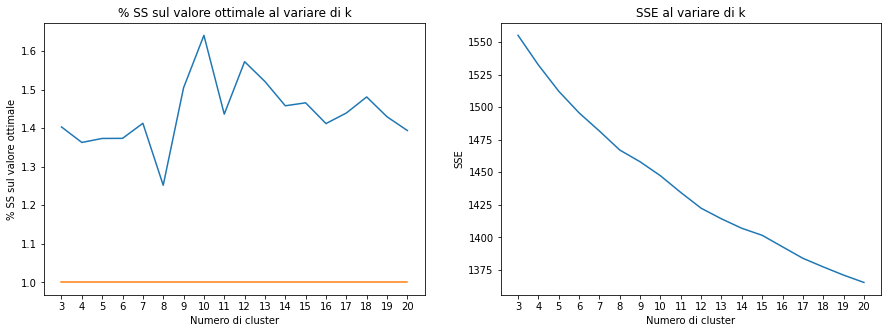

In [22]:
opt_k = find_optimal_clusters(tf_idf_matrix, 20)

## Generazione dei cluster e statistiche

In [23]:
k = opt_k
clusters = KMeans(n_clusters = k, n_init = 10, random_state = SEED).fit(tf_idf_matrix)
count = Counter(clusters.labels_)

label_cluster = list(clusters.labels_)
df_eng['cluster'] = label_cluster

print(count)

Counter({3: 455, 6: 286, 0: 269, 1: 217, 4: 190, 2: 164, 7: 155, 5: 47})


In [24]:
# Cluster per stock
df_eng.groupby('cluster')['stock'].value_counts().unstack().fillna(0).astype(int)

stock,AAPL,AMZN,BAC,DAL,GOOGL,GS,LUV,T,TWTR,VZ
cluster,,,,,,,,,,
0,4,3,115,10,9,93,5,13,4,13
1,36,18,34,20,15,37,4,23,7,23
2,80,17,1,0,39,2,0,19,4,2
3,42,112,5,24,84,19,4,43,97,25
4,0,2,2,57,0,1,126,0,2,0
5,1,3,6,3,0,4,19,8,0,3
6,9,25,15,48,35,21,5,25,62,41
7,11,5,3,2,5,2,0,48,3,76


In [25]:
# Cluster per categoria
df_eng.groupby('categoria')['cluster'].value_counts().unstack().fillna(0).astype(int)

cluster,0,1,2,3,4,5,6,7
categoria,,,,,,,,
AIR,15,24,0,28,183,22,53,2
BANK,208,71,3,24,3,10,36,5
TECH,20,76,140,335,4,4,131,24
TLC,26,46,21,68,0,11,66,124


In [26]:
# Cluster per anno
df_eng.groupby('cluster')['year'].value_counts().unstack().fillna(0).astype(int)

year,2011,2013,2015
cluster,,,
0,109,131,29
1,107,77,33
2,82,60,22
3,217,155,83
4,84,70,36
5,24,19,4
6,93,131,62
7,75,64,16


In [0]:
clusters_pred = KMeans(n_clusters = k, random_state = SEED).fit_predict(tf_idf_matrix)

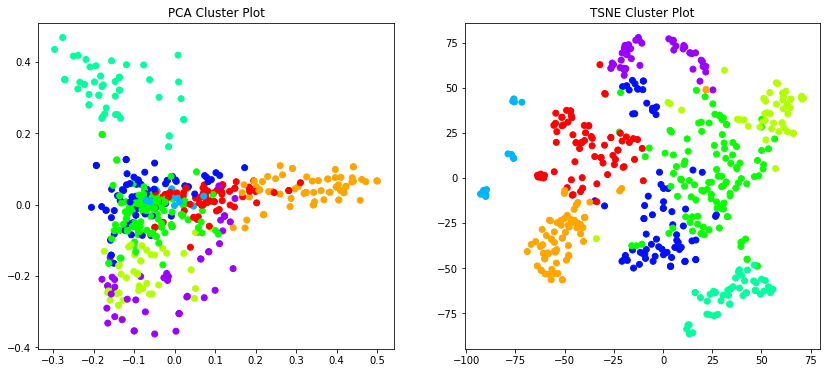

In [28]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)+2
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=True)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=12).fit_transform(data[max_items,:].todense()))
    
    idx = np.random.choice(range(pca.shape[0]), size=500, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')

text = vectorizer.transform(text_proc)
plot_tsne_pca(text, clusters_pred)

In [29]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data).groupby(clusters).mean()
    for i,r in df.iterrows():
      print('\nCluster {}'.format(i))
      print(', '.join([labels[t] for t in np.argsort(r)[:-n_terms:-1]]))
      
get_top_keywords(tf_idf_matrix, clusters_pred, vectorizer.get_feature_names(), 10)


Cluster 0
bank, invest, citi, fund, bond, deal, debt, goldman, america

Cluster 1
index, stock, point, euro, dow, nasdaq, rose, fell, gain

Cluster 2
appl, samsung, iphon, smartphon, googl, devic, mobil, tablet, android

Cluster 3
onlin, servic, amazon, twitter, network, peopl, facebook, busi, googl

Cluster 4
airlin, southwest, flight, plane, airport, delta, air, boe, carrier

Cluster 5
corp, oct, jan, earn, weekli, estim, ahead, aug, day

Cluster 6
govern, state, oil, court, rule, obama, presid, attack, law

Cluster 7
verizon, wireless, quarter, mobil, cent, revenu, analyst, custom, sprint


In [30]:
df_eng.loc[df_eng['cluster'] == 1, 'body'].head(10)

1840    NEW YORK (Reuters) - Stocks slipped on Thursda...
1464    NEW YORK (Reuters) - Stocks fell on Friday aft...
1226    NEW YORK (Reuters) - Energy shares helped the ...
692      * Trichet sees short-term inflation pressures...
773       * Jobless claims, international trade data o...
1597     (Updates with Apple developments in paragraph...
1846     (Adds futures, company news. updates snapshot...
1407      * Citi off as profit, revs miss expectations...
1003      * DuPont, Verizon, Travelers report results ...
1783      * P&G, AT&T fall after results, Caterpillar ...
Name: body, dtype: object

In [31]:
df_eng.loc[df_eng['cluster'] == 1, 'body'][1840]

"NEW YORK (Reuters) - Stocks slipped on Thursday as soft retail sales and a sharp rise in the dollar left investors edgy a day before December’s U.S. employment report.  Traders work on the floor of the New York Stock Exchange early in the trading session in New York, January 3, 2011. REUTERS/Mike SegarGiven a rise of about 8 percent in the S&P 500 since the start of December, investors could be looking for an excuse to sell stocks if the jobs report falls short of forecasts that were raised after Wednesday’s strong private-sector payroll report.  “If tomorrow’s payroll numbers don’t live up to expectations, that could create the correction that some have been predicting,” said Paul Radeke, vice president at Minneapolis-based KDV Wealth Management.  Investors expect a gain of 175,000 in overall non-farm payrolls in December and a decline in the unemployment rate to 9.7 percent from 9.8 percent.  Several big retailers missed estimates in their December comparable sales, news that weighe

In [32]:
df_eng.loc[df_eng['cluster'] == 5, 'body'].head(10)

1716     THOMSON REUTERS, January 13, 2011 Diary of S&...
1030     THOMSON REUTERS, January 13, 2011 Diary of S&...
1632     THOMSON REUTERS, S&P 500 Corporate earnings f...
262      THOMSON REUTERS, Corporate Conference Call/We...
1651    - - - - - - - - - - - - - - - - - - - - - - - ...
499      THOMSON REUTERS, Corporate Conference Call/We...
1839     THOMSON REUTERS, March 21, 2011 - Diary of S&...
1313    THOMSON REUTERS, April 25, 2011 Diary of S&P 5...
1435     THOMSON REUTERS, July 06, 2011 - Diary of S&P...
1962     THOMSON REUTERS, July 19, 2011 - Diary of S&P...
Name: body, dtype: object

In [33]:
df_eng.loc[df_eng['cluster'] == 5, 'body'][1716]

' THOMSON REUTERS, January 13, 2011 Diary of S&P 500 Corporate earnings for U.S. companies     S&P 500 Earnings - Monthly      [RESF/US]      S&P 500 Earnings - Day Ahead   [ESTEARN/SP]  Non S&P 500 - Weekly            [NSP500/WK]    Non S&P 500 - Day Ahead        [ESTEARN/]  ConferenceCall/Webcast - Weekly [US/CCALLM]    ConferenceCall/Webcast - Day   [US/CCALL]  Meetings - Weekly               [US/MEETM]     Meetings - Day Ahead           [US/MEET]  Economic Indicators             USTODAY      Dividends                       [DIV/US]  Daily earnings hits & misses    [US/EARN]  Federal Reserve events          [FED/DIARY]  Global Company News Preview     [GLO/EQUITY]    ** The EPS estimate figure is a mean average based on the amount polled.    ** EPS data from Thomson Reuters I/B/E/S Estimates     S&P 500 EARNINGS   - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - DATE     GMT/MP  COMPANY NAME AND PERIOD                   SYMBOL     EPS    

In [34]:
df_eng.loc[df_eng['cluster'] == 6, 'body'].head(10)

37          * FBI contacted Winifred Jiau before arres...
329     WARRI, Nigeria (Reuters) - The governor of one...
1646    LONDON (Reuters) - From what France calls “eco...
1742     * BofA did 14,500 Roth IRA conversions in Dec...
1477    WASHINGTON (Reuters) - An Obama administration...
613     WASHINGTON (Reuters) - The United States incre...
715      * Says Verizon, MetroPCS filed appeals too ea...
336     DAVOS, Switzerland (Reuters) - If ministers an...
265     CAIRO (Reuters) - The balance between the two ...
250     WASHINGTON (Reuters) - A group of prominent bu...
Name: body, dtype: object

In [35]:
df_eng.loc[df_eng['cluster'] == 6, 'body'][1477]

'WASHINGTON (Reuters) - An Obama administration housing official on Wednesday defended mortgage servicing companies, just one day after Treasury Secretary Timothy Geithner said the industry needs an overhaul.  Cindy Gertz, director of operations at the Treasury Department’s Homeownership Preservation Office, said mortgage servicers—firms which collect loan payments—have hired tens of thousands of extra staff to work with a crush of struggling borrowers who are trying to renegotiate the terms of their mortgages.  “I think tremendous progress has been made,” Gertz told a group of bankers at a conference organized by the Mortgage Bankers Association. Gertz, a former executive at mortgage finance giant Freddie Mac, did acknowledge that the process is not complete.  Her comments stand in stark contrast to sharp criticism by other Obama administration officials.  David Stevens, the Federal Housing Administration Commissioner, told the conference the industry has a “trust deficit” that threat

# Classificazione

Text(0, 0.5, 'Variance explained')

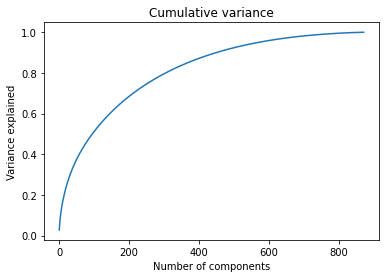

In [36]:
X = tf_idf_matrix
X_pca = PCA(random_state = SEED).fit(X)

cumvar = np.cumsum(X_pca.explained_variance_ratio_)

#Plotting cumulative variance
plt.plot(cumvar)
plt.title('Cumulative variance')
plt.xlabel('Number of components')
plt.ylabel('Variance explained')

In [37]:
cumvar[500]

0.9238188397162804

In [38]:
n_used = 500
X_pca = np.dot(X.values, X_pca.components_[:n_used,:].T)
X_pca = pd.DataFrame(X_pca, columns=["PC%d" % (x + 1) for x in range(n_used)])
X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,...,PC461,PC462,PC463,PC464,PC465,PC466,PC467,PC468,PC469,PC470,PC471,PC472,PC473,PC474,PC475,PC476,PC477,PC478,PC479,PC480,PC481,PC482,PC483,PC484,PC485,PC486,PC487,PC488,PC489,PC490,PC491,PC492,PC493,PC494,PC495,PC496,PC497,PC498,PC499,PC500
0,0.024982,-0.122794,-0.079233,0.003720,-0.000810,-0.039004,-0.286856,-0.130261,-0.188256,-0.096757,-0.019305,-0.159689,0.206795,0.046418,0.060382,0.129635,0.080958,0.107960,0.063261,0.055005,-0.066109,0.033579,-0.159852,-0.053598,0.134959,-0.150904,0.076378,-0.124966,0.144062,-0.049295,0.134771,-0.022786,-0.073307,0.036859,0.043469,-0.080544,-0.001389,0.012896,-0.084532,0.015403,...,-0.007989,0.013687,0.009712,0.005781,-0.002279,0.019630,0.003444,0.027522,0.010712,0.041344,0.046450,0.009997,-0.012484,-0.011741,-0.013542,-0.003071,-0.014062,-0.014378,0.001641,-0.006665,-0.022671,0.009654,0.005751,-0.016474,-0.002175,-0.003453,-0.013905,-0.014381,0.002127,0.002993,0.003130,0.013392,0.019966,0.024589,0.016317,0.016189,0.008109,-0.009322,0.013243,0.008122
1,0.108937,-0.119652,0.385818,0.283111,-0.140734,0.005728,-0.038468,0.035990,0.082946,-0.053241,0.002211,0.022161,-0.053313,0.012159,0.022564,-0.017310,-0.030765,-0.021047,-0.002779,0.079304,-0.044937,-0.066367,-0.013064,-0.137736,0.032682,-0.047653,0.042328,-0.002183,-0.097429,-0.080602,0.032876,0.041054,0.052136,0.045448,-0.026866,0.062118,-0.008664,0.011511,0.006737,0.029184,...,0.010376,0.000165,-0.006387,-0.017536,0.021905,-0.008960,-0.019886,-0.008028,0.005171,-0.003549,0.001722,-0.001139,-0.004346,-0.009620,0.026198,-0.000308,0.020980,-0.006120,-0.000447,-0.017835,-0.013897,0.015252,-0.000544,-0.022954,-0.035529,0.008259,-0.004518,-0.007282,-0.001001,-0.000980,-0.000894,0.015542,0.002290,0.052777,-0.021817,0.007177,-0.001136,0.015332,0.016033,-0.014288
2,0.114772,-0.113972,0.372465,0.267479,-0.141220,0.016174,-0.018134,0.021530,0.074022,-0.031287,0.004307,-0.005607,-0.065216,0.001013,0.012778,0.006696,-0.021900,-0.027743,-0.028285,0.109666,-0.040128,-0.066551,-0.009315,-0.137730,0.029414,-0.043365,0.060138,-0.000055,-0.094532,-0.081923,0.030892,0.062754,0.038997,0.048465,-0.018678,0.063733,-0.003899,0.028603,-0.006369,0.018174,...,-0.000810,-0.001747,0.001637,-0.008717,0.025907,0.000359,-0.022351,-0.008162,0.009422,0.008955,-0.013413,-0.010255,-0.007888,-0.006071,0.012112,-0.007433,0.018603,-0.012424,-0.008318,-0.014986,-0.006344,0.003388,0.001101,-0.021466,-0.038233,0.002237,-0.022544,-0.012702,0.015741,-0.003154,-0.013427,0.015436,0.007866,0.045921,-0.013653,0.007035,0.006776,0.017550,0.008450,-0.015032
3,-0.051394,-0.237371,0.191315,-0.072914,0.038847,-0.195467,0.066760,-0.065791,-0.024473,0.045764,-0.042028,-0.097183,0.027662,-0.057009,-0.116267,0.038877,-0.106372,-0.154219,-0.151359,0.053007,-0.058631,0.011573,0.021159,-0.166240,-0.001216,0.071505,0.073115,0.107370,-0.029594,0.135522,-0.104242,0.033505,0.085152,-0.023103,-0.034729,-0.146657,-0.067781,0.007342,0.094774,0.214755,...,0.003630,-0.006607,-0.001855,-0.011220,-0.011980,0.021843,-0.006631,-0.012079,-0.032600,0.009013,0.029624,0.003154,0.025437,-0.006902,-0.003715,0.005539,0.001861,-0.029795,0.013905,0.017005,0.012764,-0.008591,-0.019128,-0.025169,-0.015616,-0.008004,0.002353,-0.006353,0.021687,-0.010345,-0.030984,0.010002,0.015583,0.001871,-0.011916,-0.011963,-0.008532,-0.024734,0.019875,0.003122
4,0.449300,0.064231,0.148225,-0.106421,-0.223354,-0.005000,0.075104,-0.107134,-0.136496,-0.082106,0.101651,-0.107348,0.079842,0.026373,0.092145,-0.191809,-0.030846,-0.054104,0.014922,0.017769,-0.073017,0.026789,0.000053,-0.000595,0.030131,-0.009792,0.014120,-0.030814,-0.068920,-0.008280,-0.012474,0.018662,-0.012543,0.018029,0.023586,0.022747,-0.020151,0.029748,-0.082370,-0.022282,...,0.008391,-0.032193,-0.039685,-0.001569,-0.011786,-0.004928,0.036757,0.048253,-0.010314,0.010193,0.005285,0

## Sui cluster

In [0]:
y = df_eng['cluster'] 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.3, random_state = SEED, stratify = y)

In [0]:
levels = pd.unique(y)

In [0]:
classification_metrics = pd.DataFrame(columns=["Accuracy", "Precision", "Sensitivity", "F1 Score"])

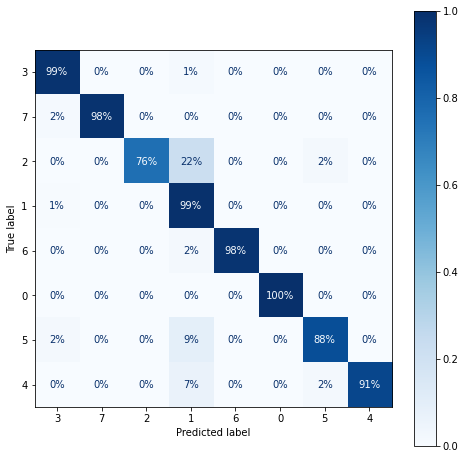

In [43]:
# LOGISTIC REGRESSION
logistic = LogisticRegression(max_iter = 10000, random_state = SEED, solver = 'lbfgs').fit(X_train, y_train)
logistic_predict = logistic.predict(X_test)

#metrics:
logi_acc = accuracy_score(logistic_predict, y_test)
logi_preci = precision_score(logistic_predict, y_test, average = 'weighted')
logi_sensitivity = recall_score(logistic_predict, y_test, average = 'weighted')
logi_f1 = f1_score(logistic_predict, y_test, average = 'weighted')

classification_metrics.loc["Logistic regression"] = [logi_acc,logi_preci,logi_sensitivity,logi_f1]
fig, ax = plt.subplots(figsize = (8,8))
plot_confusion_matrix(logistic, X_test, y_test, display_labels = levels,
                      cmap = plt.cm.Blues, 
                      values_format = '0.0%', normalize = 'true',
                      ax = ax,
                      )

In [44]:
# Decision TREE: Entropy

# Evaluating best parameters
depth = np.arange(4, 20) 
parameters = {'max_depth': depth}
clf = GridSearchCV(tree.DecisionTreeClassifier(criterion = 'entropy', random_state = SEED), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_depth = clf.best_params_['max_depth']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'max_depth': 7} with a score of 0.86


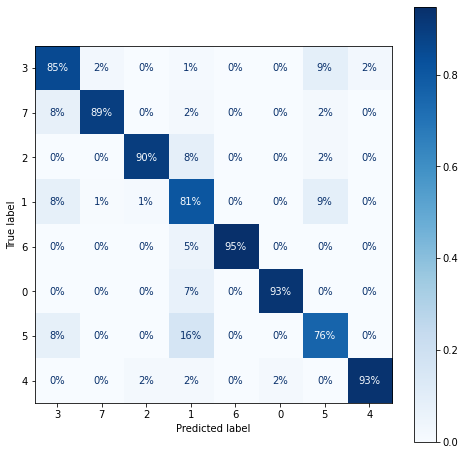

In [45]:
tree_Entropy = tree.DecisionTreeClassifier(max_depth = opt_depth, criterion = 'entropy', random_state = SEED)
tree_Entropy = tree_Entropy.fit(X_train, y_train)
tree_Entropy_pred = tree_Entropy.predict(X_test)

#metrics
tree_acc = accuracy_score(tree_Entropy_pred, y_test)
tree_preci = precision_score(tree_Entropy_pred, y_test, average = 'weighted')
tree_sensitivity = recall_score(tree_Entropy_pred, y_test, average = 'weighted')
tree_f1 = f1_score(tree_Entropy_pred, y_test, average = 'weighted')

classification_metrics.loc["Tree Entropy"] = [tree_acc, tree_preci, tree_sensitivity, tree_f1]
fig, ax = plt.subplots(figsize = (8,8))
plot_confusion_matrix(tree_Entropy, X_test, y_test, 
                      display_labels = levels, cmap = plt.cm.Blues,
                      values_format = '0.0%', normalize = 'true',
                      ax = ax
                      )

In [46]:
# Decision TREE: Gini

# Evaluating best parameters
depth = np.arange(4, 20) 
parameters = {'max_depth': depth}
clf = GridSearchCV(tree.DecisionTreeClassifier(criterion = 'gini', random_state = SEED), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_depth = clf.best_params_['max_depth']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'max_depth': 7} with a score of 0.87


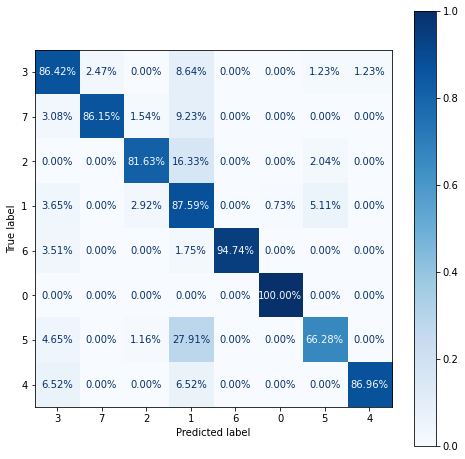

In [47]:
tree_Gini = tree.DecisionTreeClassifier(max_depth = opt_depth, criterion = 'gini', random_state = SEED)
tree_Gini = tree_Gini.fit(X_train, y_train)
tree_Gini_pred = tree_Gini.predict(X_test)

#metrics
tree_acc = accuracy_score(tree_Gini_pred, y_test)
tree_preci = precision_score(tree_Gini_pred, y_test, average = 'weighted')
tree_sensitivity = recall_score(tree_Gini_pred, y_test, average = 'weighted')
tree_f1 = f1_score(tree_Gini_pred, y_test, average = 'weighted')

classification_metrics.loc["Tree Gini"] = [tree_acc, tree_preci, tree_sensitivity, tree_f1]
fig, ax = plt.subplots(figsize = (8,8))
plot_confusion_matrix(tree_Gini, X_test, y_test, display_labels = levels, cmap = plt.cm.Blues, 
                      values_format = '0.2%',  normalize = 'true',
                      ax = ax
                      )

In [48]:
# Random forest - Entropy criterion

# Evaluating best parameters
depth = np.arange(4, 20) 
parameters = {'max_depth': depth}
clf = GridSearchCV(RandomForestClassifier(criterion = 'entropy', n_estimators = 200, random_state = SEED,
                                          ), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_depth = clf.best_params_['max_depth']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'max_depth': 12} with a score of 0.90


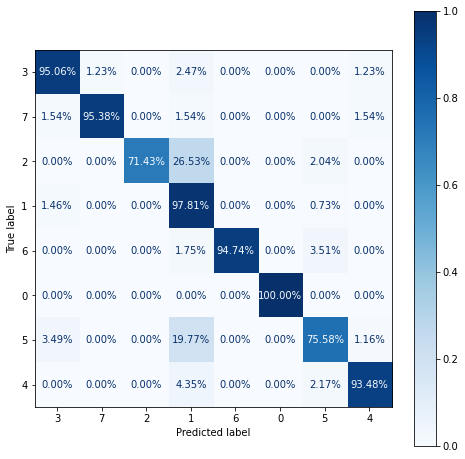

In [49]:
forest_Entropy = RandomForestClassifier(max_depth = opt_depth, criterion = 'entropy', n_estimators = 200, random_state = SEED)
forest_Entropy = forest_Entropy.fit(X_train, y_train)
forest_Entropy_pred = forest_Entropy.predict(X_test)

#metrics
forest_acc = accuracy_score(forest_Entropy_pred, y_test)
forest_preci = precision_score(forest_Entropy_pred, y_test, average = 'weighted')
forest_sensitivity = recall_score(forest_Entropy_pred, y_test, average = 'weighted')
forest_f1 = f1_score(forest_Entropy_pred, y_test, average = 'weighted')

classification_metrics.loc["Forest Entropy"] = [forest_acc,forest_preci,forest_sensitivity,forest_f1]
fig, ax = plt.subplots(figsize = (8,8))
plot_confusion_matrix(forest_Entropy, X_test, y_test, display_labels = levels,
                      cmap = plt.cm.Blues, 
                      values_format = '0.2%', normalize = 'true',
                      ax = ax
                      )

In [50]:
# Random forest - Gini criterion

# Evaluating best parameters
depth = np.arange(4, 20) 
parameters = {'max_depth': depth}
clf = GridSearchCV(RandomForestClassifier(criterion = 'gini', n_estimators = 200, random_state = SEED,
                                          ), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_depth = clf.best_params_['max_depth']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'max_depth': 13} with a score of 0.91


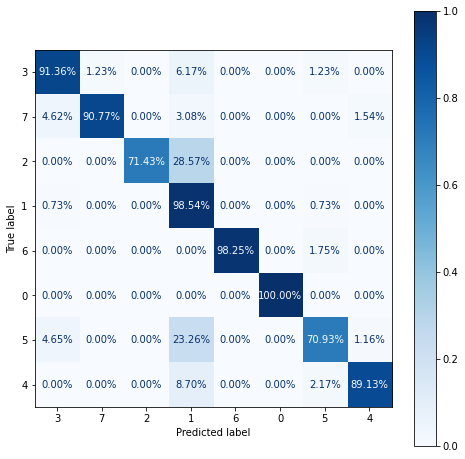

In [51]:
forest_Gini = RandomForestClassifier(max_depth = opt_depth, criterion = 'gini', n_estimators = 200, random_state = SEED)
forest_Gini = forest_Gini.fit(X_train, y_train)
forest_Gini_pred = forest_Gini.predict(X_test)

#metrics
forest_acc = accuracy_score(forest_Gini_pred, y_test)
forest_preci = precision_score(forest_Gini_pred, y_test, average = 'weighted')
forest_sensitivity = recall_score(forest_Gini_pred, y_test, average = 'weighted')
forest_f1 = f1_score(forest_Gini_pred, y_test, average = 'weighted')

classification_metrics.loc["Forest Gini"] = [forest_acc,forest_preci,forest_sensitivity,forest_f1]
fig, ax = plt.subplots(figsize = (8,8))
plot_confusion_matrix(forest_Gini, X_test, y_test, display_labels = levels,
                      cmap = plt.cm.Blues, 
                      values_format = '0.2%', normalize = 'true',
                      ax = ax
                      )

In [52]:
# KNN

# Evaluating best parameters
neigh = np.arange(2, 20)
parameters = {'n_neighbors': neigh}
clf = GridSearchCV(KNeighborsClassifier(), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_neigh = clf.best_params_['n_neighbors']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'n_neighbors': 17} with a score of 0.88


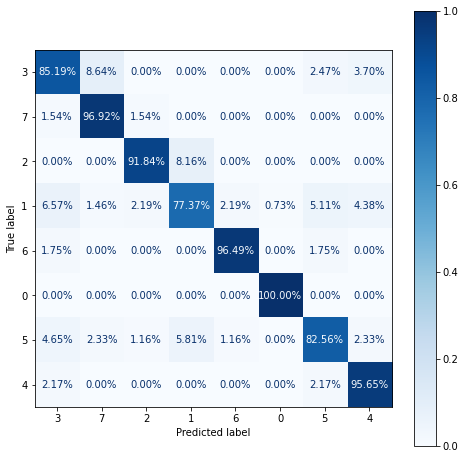

In [53]:
knn = KNeighborsClassifier(opt_neigh)
knn = knn.fit(X_train, y_train)
neigh_predict = knn.predict(X_test)

#metrics:
neigh_acc = accuracy_score(neigh_predict, y_test)
neigh_preci = precision_score(neigh_predict, y_test, average = 'weighted')
neigh_sensitivity = recall_score(neigh_predict, y_test, average = 'weighted')
neigh_f1 = f1_score(neigh_predict, y_test, average = 'weighted')

classification_metrics.loc["KNN"] = [neigh_acc,neigh_preci,neigh_sensitivity,neigh_f1]
fig, ax = plt.subplots(figsize = (8,8))
plot_confusion_matrix(knn, X_test, y_test, display_labels = levels,
                      cmap = plt.cm.Blues, 
                      values_format = '0.2%', normalize = 'true',
                      ax = ax
                      )

In [54]:
classification_metrics.sort_values('F1 Score')

,Accuracy,Precision,Sensitivity,F1 Score
Tree Gini,0.842991,0.851261,0.842991,0.841905
Tree Entropy,0.854206,0.853118,0.854206,0.852880
KNN,0.872897,0.880866,0.872897,0.874026
Forest Gini,0.887850,0.906908,0.887850,0.888247
Forest Entropy,0.904673,0.918385,0.904673,0.905448
Logistic regression,0.943925,0.951486,0.943925,0.944328


## Sulle categorie

In [0]:
y = df_eng['categoria'] 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.3, random_state = SEED, stratify = y)

In [0]:
levels = pd.unique(y)

In [0]:
classification_metrics = pd.DataFrame(columns=["Accuracy", "Precision", "Sensitivity", "F1 Score"])

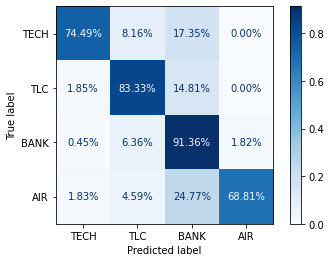

In [59]:
# LOGISTIC REGRESSION
logistic = LogisticRegression(max_iter = 10000, random_state = SEED, solver = 'lbfgs').fit(X_train, y_train)
logistic_predict = logistic.predict(X_test)

#metrics:
logi_acc = accuracy_score(logistic_predict, y_test)
logi_preci = precision_score(logistic_predict, y_test, average = 'weighted')
logi_sensitivity = recall_score(logistic_predict, y_test, average = 'weighted')
logi_f1 = f1_score(logistic_predict, y_test, average = 'weighted')

classification_metrics.loc["Logistic regression"] = [logi_acc,logi_preci,logi_sensitivity,logi_f1]
plot_confusion_matrix(logistic, X_test, y_test, display_labels = levels,
                      cmap = plt.cm.Blues, 
                      values_format = '0.2%', normalize = 'true',
                      )

In [60]:
# Decision TREE: Entropy

# Evaluating best parameters
depth = np.arange(4, 20) 
parameters = {'max_depth': depth}
clf = GridSearchCV(tree.DecisionTreeClassifier(criterion = 'entropy', random_state = SEED), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_depth = clf.best_params_['max_depth']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'max_depth': 5} with a score of 0.72


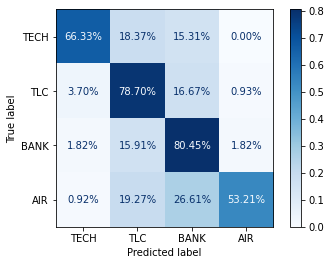

In [61]:
tree_Entropy = tree.DecisionTreeClassifier(max_depth = opt_depth, criterion = 'entropy', random_state = SEED)
tree_Entropy = tree_Entropy.fit(X_train, y_train)
tree_Entropy_pred = tree_Entropy.predict(X_test)

#metrics
tree_acc = accuracy_score(tree_Entropy_pred, y_test)
tree_preci = precision_score(tree_Entropy_pred, y_test, average = 'weighted')
tree_sensitivity = recall_score(tree_Entropy_pred, y_test, average = 'weighted')
tree_f1 = f1_score(tree_Entropy_pred, y_test, average = 'weighted')

classification_metrics.loc["Tree Entropy"] = [tree_acc, tree_preci, tree_sensitivity, tree_f1]
plot_confusion_matrix(tree_Entropy, X_test, y_test, 
                      display_labels = levels, cmap = plt.cm.Blues,
                      values_format = '0.2%', normalize = 'true',
                      )

In [62]:
# Decision TREE: Gini

# Evaluating best parameters
depth = np.arange(4, 20) 
parameters = {'max_depth': depth}
clf = GridSearchCV(tree.DecisionTreeClassifier(criterion = 'gini', random_state = SEED), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_depth = clf.best_params_['max_depth']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'max_depth': 5} with a score of 0.72


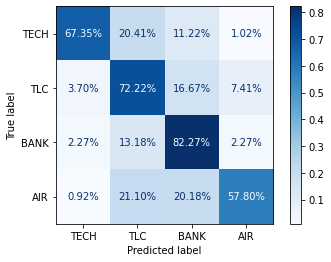

In [63]:
tree_Gini = tree.DecisionTreeClassifier(max_depth = opt_depth, criterion = 'gini', random_state = SEED)
tree_Gini = tree_Gini.fit(X_train, y_train)
tree_Gini_pred = tree_Gini.predict(X_test)

#metrics
tree_acc = accuracy_score(tree_Gini_pred, y_test)
tree_preci = precision_score(tree_Gini_pred, y_test, average = 'weighted')
tree_sensitivity = recall_score(tree_Gini_pred, y_test, average = 'weighted')
tree_f1 = f1_score(tree_Gini_pred, y_test, average = 'weighted')

classification_metrics.loc["Tree Gini"] = [tree_acc, tree_preci, tree_sensitivity, tree_f1]
plot_confusion_matrix(tree_Gini, X_test, y_test, display_labels = levels, cmap = plt.cm.Blues, 
                      values_format = '0.2%',  normalize = 'true',
                      )

In [64]:
# Random forest - Entropy criterion

# Evaluating best parameters
depth = np.arange(4, 20) 
parameters = {'max_depth': depth}
clf = GridSearchCV(RandomForestClassifier(criterion = 'entropy', n_estimators = 200, random_state = SEED,
                                          ), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_depth = clf.best_params_['max_depth']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'max_depth': 18} with a score of 0.70


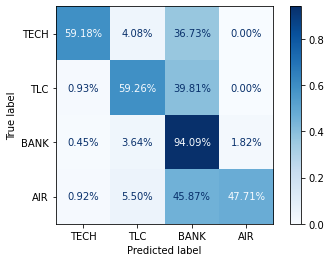

In [65]:
forest_Entropy = RandomForestClassifier(max_depth = opt_depth, criterion = 'entropy', n_estimators = 200, random_state = SEED)
forest_Entropy = forest_Entropy.fit(X_train, y_train)
forest_Entropy_pred = forest_Entropy.predict(X_test)

#metrics
forest_acc = accuracy_score(forest_Entropy_pred, y_test)
forest_preci = precision_score(forest_Entropy_pred, y_test, average = 'weighted')
forest_sensitivity = recall_score(forest_Entropy_pred, y_test, average = 'weighted')
forest_f1 = f1_score(forest_Entropy_pred, y_test, average = 'weighted')

classification_metrics.loc["Forest Entropy"] = [forest_acc,forest_preci,forest_sensitivity,forest_f1]
plot_confusion_matrix(forest_Entropy, X_test, y_test, display_labels = levels,
                      cmap = plt.cm.Blues, 
                      values_format = '0.2%', normalize = 'true',
                      )

In [66]:
# Random forest - Gini criterion

# Evaluating best parameters
depth = np.arange(4, 20) 
parameters = {'max_depth': depth}
clf = GridSearchCV(RandomForestClassifier(criterion = 'gini', n_estimators = 200, random_state = SEED,
                                          ), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_depth = clf.best_params_['max_depth']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'max_depth': 17} with a score of 0.70


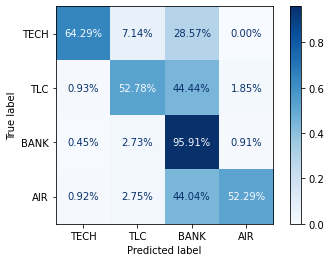

In [67]:
forest_Gini = RandomForestClassifier(max_depth = opt_depth, criterion = 'gini', n_estimators = 200, random_state = SEED)
forest_Gini = forest_Gini.fit(X_train, y_train)
forest_Gini_pred = forest_Gini.predict(X_test)

#metrics
forest_acc = accuracy_score(forest_Gini_pred, y_test)
forest_preci = precision_score(forest_Gini_pred, y_test, average = 'weighted')
forest_sensitivity = recall_score(forest_Gini_pred, y_test, average = 'weighted')
forest_f1 = f1_score(forest_Gini_pred, y_test, average = 'weighted')

classification_metrics.loc["Forest Gini"] = [forest_acc,forest_preci,forest_sensitivity,forest_f1]
plot_confusion_matrix(forest_Gini, X_test, y_test, display_labels = levels,
                      cmap = plt.cm.Blues, 
                      values_format = '0.2%', normalize = 'true',
                      )

In [68]:
# KNN

# Evaluating best parameters
neigh = np.arange(2, 20)
parameters = {'n_neighbors': neigh}
clf = GridSearchCV(KNeighborsClassifier(), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_neigh = clf.best_params_['n_neighbors']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'n_neighbors': 19} with a score of 0.74


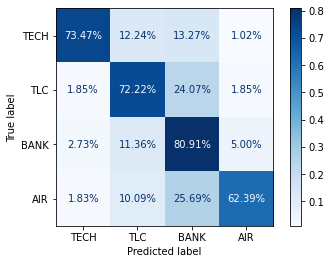

In [69]:
knn = KNeighborsClassifier(opt_neigh)
knn = knn.fit(X_train, y_train)
neigh_predict = knn.predict(X_test)

#metrics:
neigh_acc = accuracy_score(neigh_predict, y_test)
neigh_preci = precision_score(neigh_predict, y_test, average = 'weighted')
neigh_sensitivity = recall_score(neigh_predict, y_test, average = 'weighted')
neigh_f1 = f1_score(neigh_predict, y_test, average = 'weighted')

classification_metrics.loc["KNN"] = [neigh_acc,neigh_preci,neigh_sensitivity,neigh_f1]
plot_confusion_matrix(knn, X_test, y_test, display_labels = levels,
                      cmap = plt.cm.Blues, 
                      values_format = '0.2%', normalize = 'true',
                      )

In [70]:
classification_metrics.sort_values('F1 Score')

,Accuracy,Precision,Sensitivity,F1 Score
Tree Entropy,0.719626,0.747719,0.719626,0.717722
Forest Entropy,0.712150,0.799170,0.712150,0.720055
Tree Gini,0.725234,0.738120,0.725234,0.722092
Forest Gini,0.725234,0.811497,0.725234,0.733293
KNN,0.740187,0.748838,0.740187,0.739359
Logistic regression,0.820561,0.838166,0.820561,0.821438
